# CTE TRANSMISSIBILITY

Creating full matrix A and reducing (deleting dirichlet equations)

A_red (Option A)
 [[ 4.e-07 -1.e-07 -1.e-07 -1.e-07  0.e+00  0.e+00]
 [-1.e-07  4.e-07 -1.e-07 -1.e-07 -1.e-07  0.e+00]
 [-1.e-07 -1.e-07  4.e-07  0.e+00 -1.e-07 -1.e-07]
 [-1.e-07 -1.e-07  0.e+00  2.e-07  0.e+00  0.e+00]
 [ 0.e+00 -1.e-07 -1.e-07  0.e+00  6.e-07 -1.e-07]
 [ 0.e+00  0.e+00 -1.e-07  0.e+00 -1.e-07  2.e-07]]
q_red (Option A)
 [1.1e-06 0.0e+00 0.0e+00 0.0e+00 4.3e-07 0.0e+00]
[6.55352113 4.93661972 4.53239437 5.74507042 2.91549296 3.72394366]
Nodal preassure P: [6.55352113 4.93661972 4.53239437 5.74507042 2.91549296 1.
 2.         3.72394366 1.5        0.8       ]
Flow in edges: [1.6169014084507047e-07, 2.021126760563381e-07, 5.553521126760562e-07, -8.084507042253514e-08, 2.0211267605633785e-07, 1.6169014084507023e-07, 4.042253521126762e-08, 8.084507042253533e-08, 9.154929577464785e-08, -8.084507042253524e-08, 8.084507042253501e-08, 1.4154929577464784e-07, 2.115492957746478e-07]


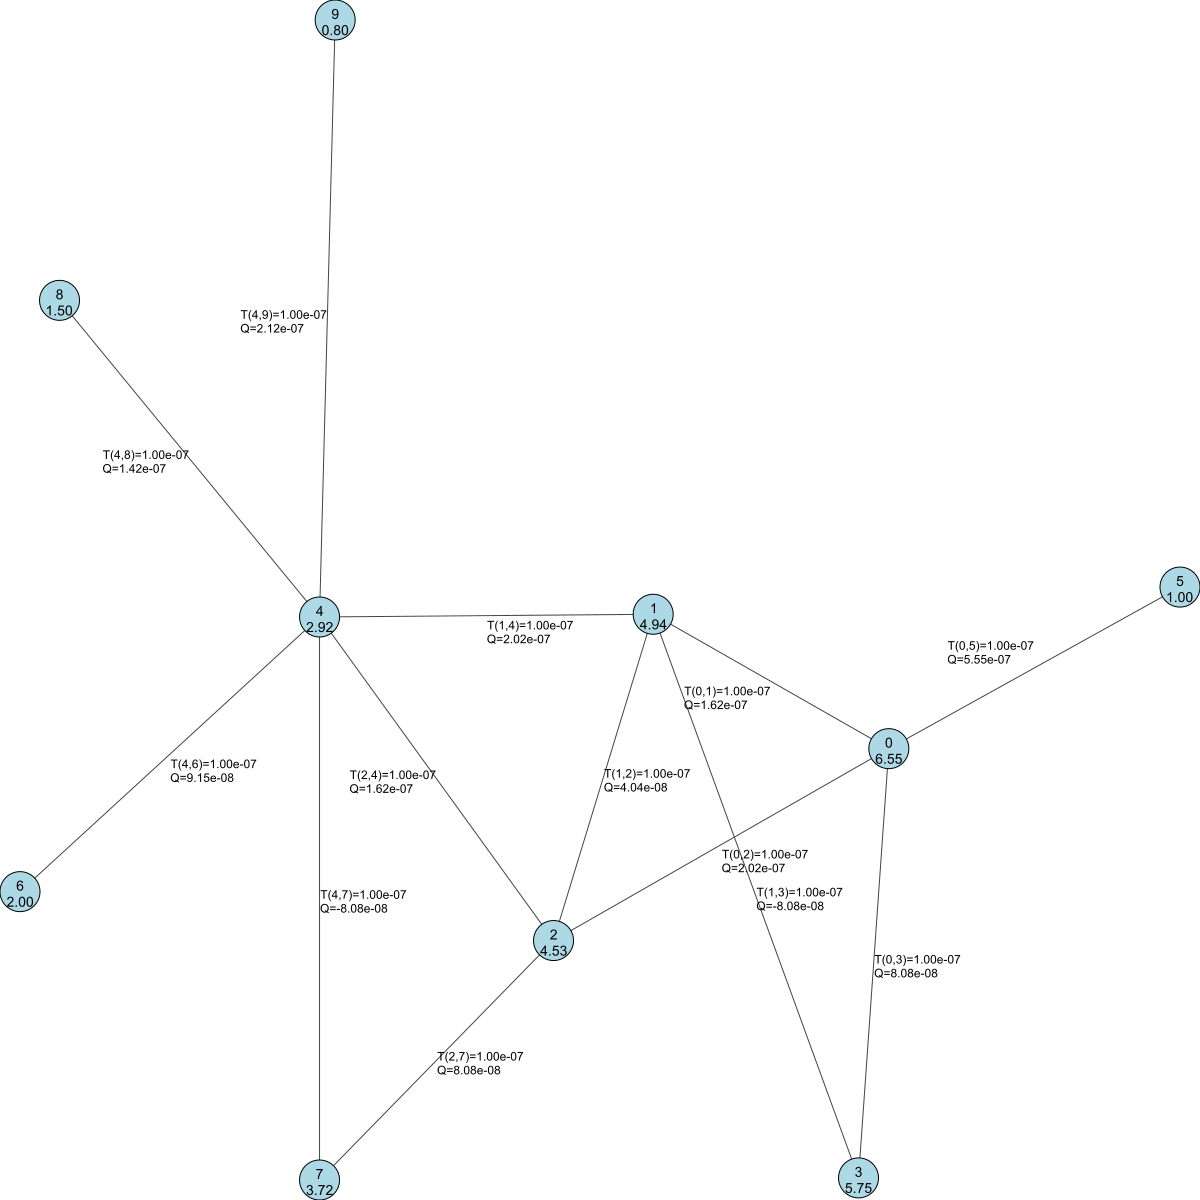

In [12]:
import igraph as ig
import numpy as np

# Create an empty graph
g = ig.Graph()

# Add nodes
g.add_vertices(10)

# Add edges
e = [(0,1), (0,2), (0,5), (1,3), (1,4), (2,4), (2,1), (3,0), (4,6), (4,7), 
     (7,2), (8,4), (9,4)]

g.add_edges(e)
ig.plot(g, vertex_label=range(10), vertex_size=30)

# Transmissibilities
D = 0.01      # 1 cm
L = 0.1
T = (D**4)/L
# Adding transmissibility attribute
g.es['T'] = [T] * g.ecount()

# Matrix A
n = g.vcount()
A = np.zeros((n,n))
# Fill matrix A with transmissibilities
for edge in g.es:
    i, j = edge.tuple
    Tij = edge['T']
    A[i,i] += Tij
    A[j,j] += Tij
    A[i,j] -= Tij
    A[j,i] -= Tij

# Matrix Q (flow matrix)
Q = np.zeros(n)
 # Neumann condition (inflow in node O)
Q[0] = 1e-6 

# Matrix P with dirichlet nodes 
P_dirichlet = np.zeros(n)
dirichlet_nodes  = [5, 6, 8, 9]
dirichlet_values = [1.0, 2.0, 1.5, 0.8]

# Right hand side of the equation (Q = Tij*P_dirichlet[j])
for node, val in zip(dirichlet_nodes, dirichlet_values):
    P_dirichlet[node] = val
    Q -= A[:, node] * P_dirichlet[node]
#print("A:", A)
#print("Q:", Q)



# Reduce matrixes to only solve por unknows preassures 
A_reduced = np.delete(A, dirichlet_nodes, axis=0)
A_reduced = np.delete(A_reduced, dirichlet_nodes, axis=1)
Q_reduced = np.delete(Q, dirichlet_nodes)

print("A_red (Option A)\n", A_reduced)
print("q_red (Option A)\n", Q_reduced)

# Solve system
P_unknows = np.linalg.solve(A_reduced, Q_reduced)
print(P_unknows)

# Reconstruct whole preassure vector
P_all = np.zeros(n)
free_nodes = [i for i in range(n) if i not in dirichlet_nodes]
P_all[free_nodes] = P_unknows
P_all[dirichlet_nodes] = dirichlet_values

# Compute flow 
flows = [float(edge['T']*(P_all[i]-P_all[j])) for edge in g.es for i,j in [edge.tuple]]

# Show results
print("Nodal preassure P:", P_all)
print("Flow in edges:", flows)

# Plot
g.vs['label'] = [f"{i}\n{P_all[i]:.2f}" for i in range(n)]
g.es['label'] = [f"{edge['T']}" for edge in g.es]
g.es['flow'] = flows
g.es['edge_label'] = [
    f"T({i},{j})={edge['T']:.2e}\nQ={edge['flow']:.2e}"
    for edge, (i, j) in zip(g.es, [e.tuple for e in g.es])
]

layout = g.layout("kk")
ig.plot(g, layout=layout, vertex_size=40, vertex_color="lightblue",
        vertex_label=g.vs['label'], edge_label=g.es['edge_label'],
        target="blood_flow_toy_graph.png", edge_label_angle_auto=True,  bbox=(1200, 1200) )


Creating matrix A reduce directly (no dirichlet equations)

A_reduced (Option B):
 [[ 4.e-07 -1.e-07 -1.e-07 -1.e-07  0.e+00  0.e+00]
 [-1.e-07  4.e-07 -1.e-07 -1.e-07 -1.e-07  0.e+00]
 [-1.e-07 -1.e-07  4.e-07  0.e+00 -1.e-07 -1.e-07]
 [-1.e-07 -1.e-07  0.e+00  2.e-07  0.e+00  0.e+00]
 [ 0.e+00 -1.e-07 -1.e-07  0.e+00  6.e-07 -1.e-07]
 [ 0.e+00  0.e+00 -1.e-07  0.e+00 -1.e-07  2.e-07]]
Q_reduced (Option B):
 [1.1e-06 0.0e+00 0.0e+00 0.0e+00 4.3e-07 0.0e+00]
P_free (Option B):
 [6.55352113 4.93661972 4.53239437 5.74507042 2.91549296 3.72394366]
Nodal preassure P (Option B): [6.55352113 4.93661972 4.53239437 5.74507042 2.91549296 1.
 2.         3.72394366 1.5        0.8       ]
Flow in edges (Option B): [1.6169014084507047e-07, 2.021126760563381e-07, 5.553521126760562e-07, -8.084507042253514e-08, 2.0211267605633785e-07, 1.6169014084507023e-07, 4.042253521126762e-08, 8.084507042253533e-08, 9.154929577464785e-08, -8.084507042253524e-08, 8.084507042253501e-08, 1.4154929577464784e-07, 2.115492957746478e-07]


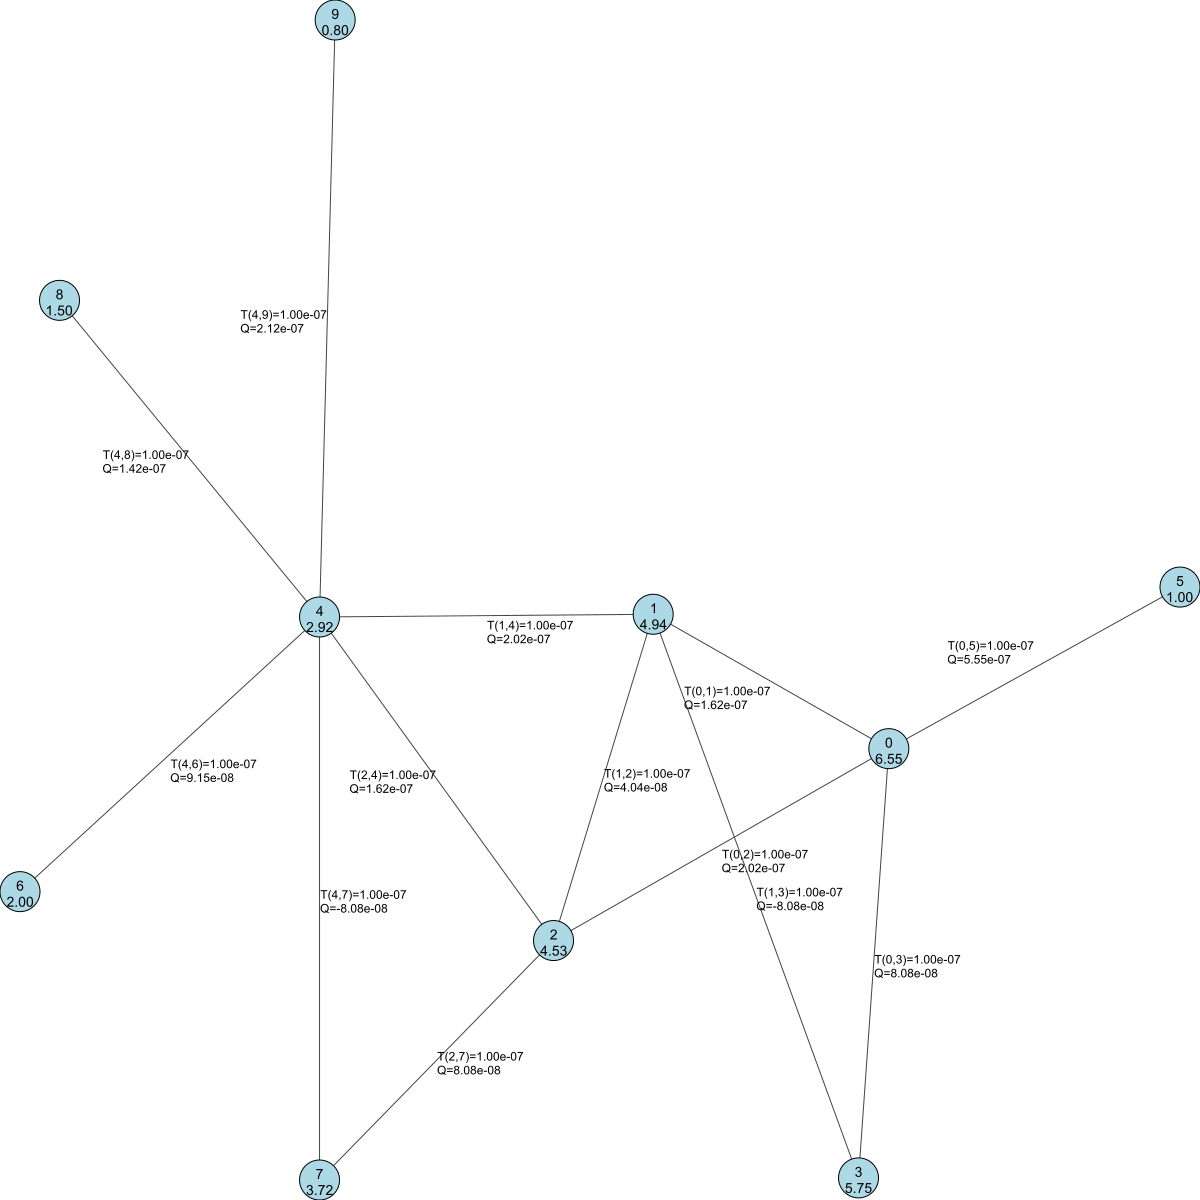

In [13]:
import igraph as ig
import numpy as np

# Create graph
g = ig.Graph()
n = 10 
g.add_vertices(n)
edges = [(0,1),(0,2),(0,5),(1,3),(1,4),(2,4),(2,1),(3,0),
         (4,6),(4,7),(7,2),(8,4),(9,4)]
g.add_edges(edges)

# Assign Transmissibilities
D = 0.01
L = 0.1
T = (D**4)/L 
g.es['T'] = [T] * g.ecount()

# Define Dirichlet nodes and values
dirichlet_nodes  = [5, 6, 8, 9]
dirichlet_values = [1.0, 2.0, 1.5, 0.8]
P_dirichlet = dict(zip(dirichlet_nodes, dirichlet_values))

# Identify free nodes and create index mapping for reduced matrix
free_nodes = [i for i in range(g.vcount()) if i not in dirichlet_nodes]
nf = len(free_nodes)
idx = {node:i for i, node in enumerate(free_nodes)} # map from original node to reduced matrix index

# Construct A_reduced (Reduced Transmissibility Matrix) - only unknown pressures (free nodes)
A_reduced = np.zeros((nf, nf))
# Fill A_reduced --> Even if we are only interested in free nodes, the entries of the dirichlet nodes should 
# contribute to the diagonal of the free nodes.
for edge in g.es:
    i, j = edge.tuple
    Tij = edge['T']

    if i in idx: # free node
        i_red = idx[i] # convert index from original to reduced matrix 
        # The diagnonal sums ALL T (including dirichlet)
        A_reduced[i_red, i_red] += Tij
        
    if j in idx:
        j_red = idx[j]
        A_reduced[j_red, j_red] += Tij
        
    # Outside diagonal entries (only interested in free nodes)
    if i in idx and j in idx:
        i_red = idx[i]
        j_red = idx[j]
        A_reduced[i_red, j_red] -= Tij
        A_reduced[j_red, i_red] -= Tij
# Construct Q_reduced
Q_reduced = np.zeros(nf)  
# Assign Neumann condition (inflow at node 0)
Q_reduced[idx[0]] = 1e-6  
    
# Dirichlet contributions to Q_reduced
for edge in g.es:
    i, j = edge.tuple
    Tij = edge['T']
    if i in idx and j in P_dirichlet: # Tij*(pi-pj) = Tij*pi - Tij*P_dirichlet[j] -- dirichlet only in j
        Q_reduced[idx[i]] += Tij * P_dirichlet[j]
        

# Solve system for unknown pressures
P_free = np.linalg.solve(A_reduced, Q_reduced)

# Reconstruct full pressure vector
P_all = np.zeros(n)
for node, val in P_dirichlet.items():
    P_all[node] = val
for node in free_nodes:
    P_all[node] = P_free[idx[node]]

# Compute flow 
flows = [float(edge['T']*(P_all[i]-P_all[j])) for edge in g.es for i,j in [edge.tuple]]

# Show results
print("A_reduced (Option B):\n", A_reduced)
print("Q_reduced (Option B):\n", Q_reduced)
print("P_free (Option B):\n", P_free)
print("Nodal preassure P (Option B):", P_all)
print("Flow in edges (Option B):", flows)


# Plot
g.vs['label'] = [f"{i}\n{P_all[i]:.2f}" for i in range(n)]
g.es['label'] = [f"{edge['T']}" for edge in g.es]
g.es['flow'] = flows
g.es['edge_label'] = [
    f"T({i},{j})={edge['T']:.2e}\nQ={edge['flow']:.2e}"
    for edge, (i, j) in zip(g.es, [e.tuple for e in g.es])
]

layout = g.layout("kk")
ig.plot(g, layout=layout, vertex_size=40, vertex_color="lightblue",
        vertex_label=g.vs['label'], edge_label=g.es['edge_label'],
        target="blood_flow_toy_graph_optionB.png", edge_label_angle_auto=True,  bbox=(1200, 1200) )


# DIFFERENT TRANSMISIBILITY FOR EACH EDGE

red [[ 4.e-07 -1.e-07 -1.e-07 -1.e-07  0.e+00  0.e+00]
 [-1.e-07  4.e-07 -1.e-07 -1.e-07 -1.e-07  0.e+00]
 [-1.e-07 -1.e-07  4.e-07  0.e+00 -1.e-07 -1.e-07]
 [-1.e-07 -1.e-07  0.e+00  2.e-07  0.e+00  0.e+00]
 [ 0.e+00 -1.e-07 -1.e-07  0.e+00  6.e-07 -1.e-07]
 [ 0.e+00  0.e+00 -1.e-07  0.e+00 -1.e-07  2.e-07]]
q_red [1.2e-06 0.0e+00 0.0e+00 0.0e+00 8.6e-07 0.0e+00]
Nodal preassure P: [7.75492958 6.21126761 5.82535211 6.98309859 4.28169014 1.
 2.         5.05352113 1.5        0.8       ]
Flow in edges:


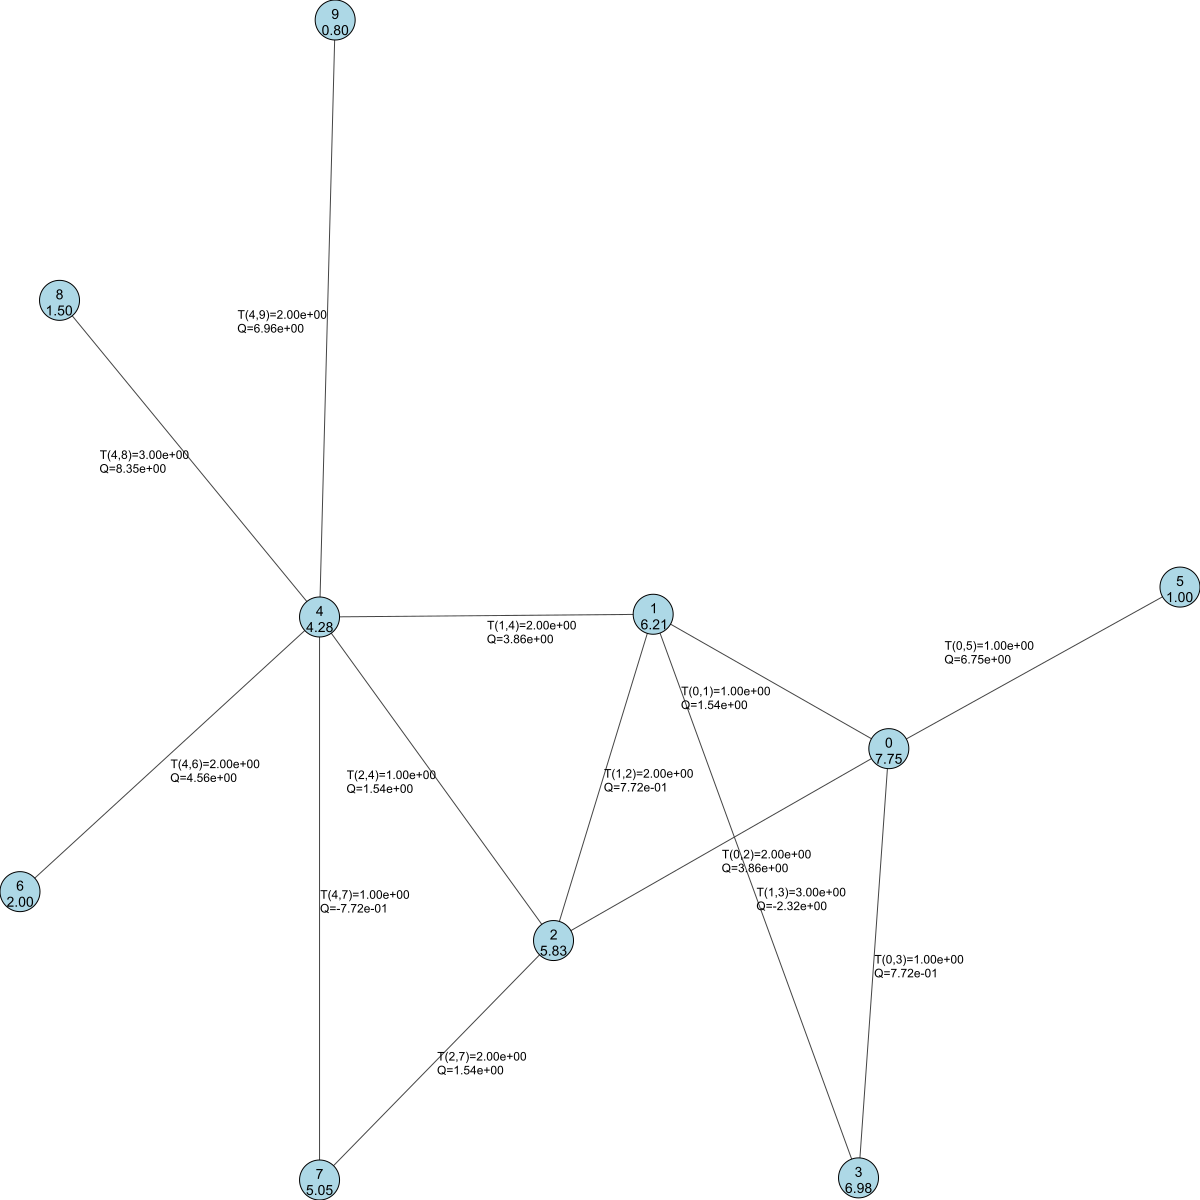

In [14]:
import igraph as ig
import numpy as np

# Create an empty graph
g = ig.Graph()

# Add nodes
g.add_vertices(10)

# Add edges
aristas = [(0,1), (0,2), (0,5), (1,3), (1,4), (2,4), (2,1), (3,0), (4,6), (4,7), 
     (7,2), (8,4), (9,4)]

g.add_edges(aristas)
ig.plot(g, vertex_label=range(10), vertex_size=30)

# Transmissibilities  
n = g.vcount()
g.es['T'] = [1, 2, 1, 3, 2, 1, 2, 1, 2, 1, 2, 3, 2]  

# Matrix P with dirichlet nodes 
P_dirichlet = np.zeros(n)
dirichlet_nodes  = [5, 6, 8, 9]
dirichlet_values = [1.0, 2.0, 1.5, 0.8]

# Right hand side of the equation (Q = Tij*P_dirichlet[j])
for node, val in zip(dirichlet_nodes, dirichlet_values):
    P_dirichlet[node] = val
    Q -= A[:, node] * P_dirichlet[node]
#print("A:", A)
#print("Q:", Q)



# Reduce matrixes to only solve por unknows preassures 
A_reduced = np.delete(A, dirichlet_nodes, axis=0)
A_reduced = np.delete(A_reduced, dirichlet_nodes, axis=1)
Q_reduced = np.delete(Q, dirichlet_nodes)

print("red", A_reduced)
print("q_red", Q_reduced)

# Solve system
P_unknows = np.linalg.solve(A_reduced, Q_reduced)


# Reconstruct whole preassure vector
P_all = np.zeros(n)
free_nodes = [i for i in range(n) if i not in dirichlet_nodes]
P_all[free_nodes] = P_unknows
P_all[dirichlet_nodes] = dirichlet_values

# Compute flow 
flows = [float(edge['T']*(P_all[i]-P_all[j])) for edge in g.es for i,j in [edge.tuple]]

# Show results
print("Nodal preassure P:", P_all)
print("Flow in edges:")

# Plot
g.vs['label'] = [f"{i}\n{P_all[i]:.2f}" for i in range(n)]
g.es['label'] = [f"{edge['T']}" for edge in g.es]
g.es['flow'] = flows
g.es['edge_label'] = [
    f"T({i},{j})={edge['T']:.2e}\nQ={edge['flow']:.2e}"
    for edge, (i, j) in zip(g.es, [e.tuple for e in g.es])
]

layout = g.layout("kk")
ig.plot(g, layout=layout, vertex_size=40, vertex_color="lightblue",
        vertex_label=g.vs['label'], edge_label=g.es['edge_label'],
        target="blood_flow_toy_graph.png", edge_label_angle_auto=True,  bbox=(1200, 1200) )


# DIFFERENT EDGES LENGHTS & DIAMETERS 

Nodal preassure P: [129.77699061 100.56198509  84.91534117 100.56198509  43.50142744
   1.           2.          57.52518659   1.5          0.8       ]
Flow in edges: [3.651875689581594e-07, 2.871145563983034e-07, 3.476978746435373e-07, 0.0, 3.6518756895815914e-07, 1.1181756706865156e-07, 2.656091356310554e-07, -1.752969893296517e-07, 1.752969893296517e-07, 1.1340385409435149e-07, 2.7328913563105545e-07]


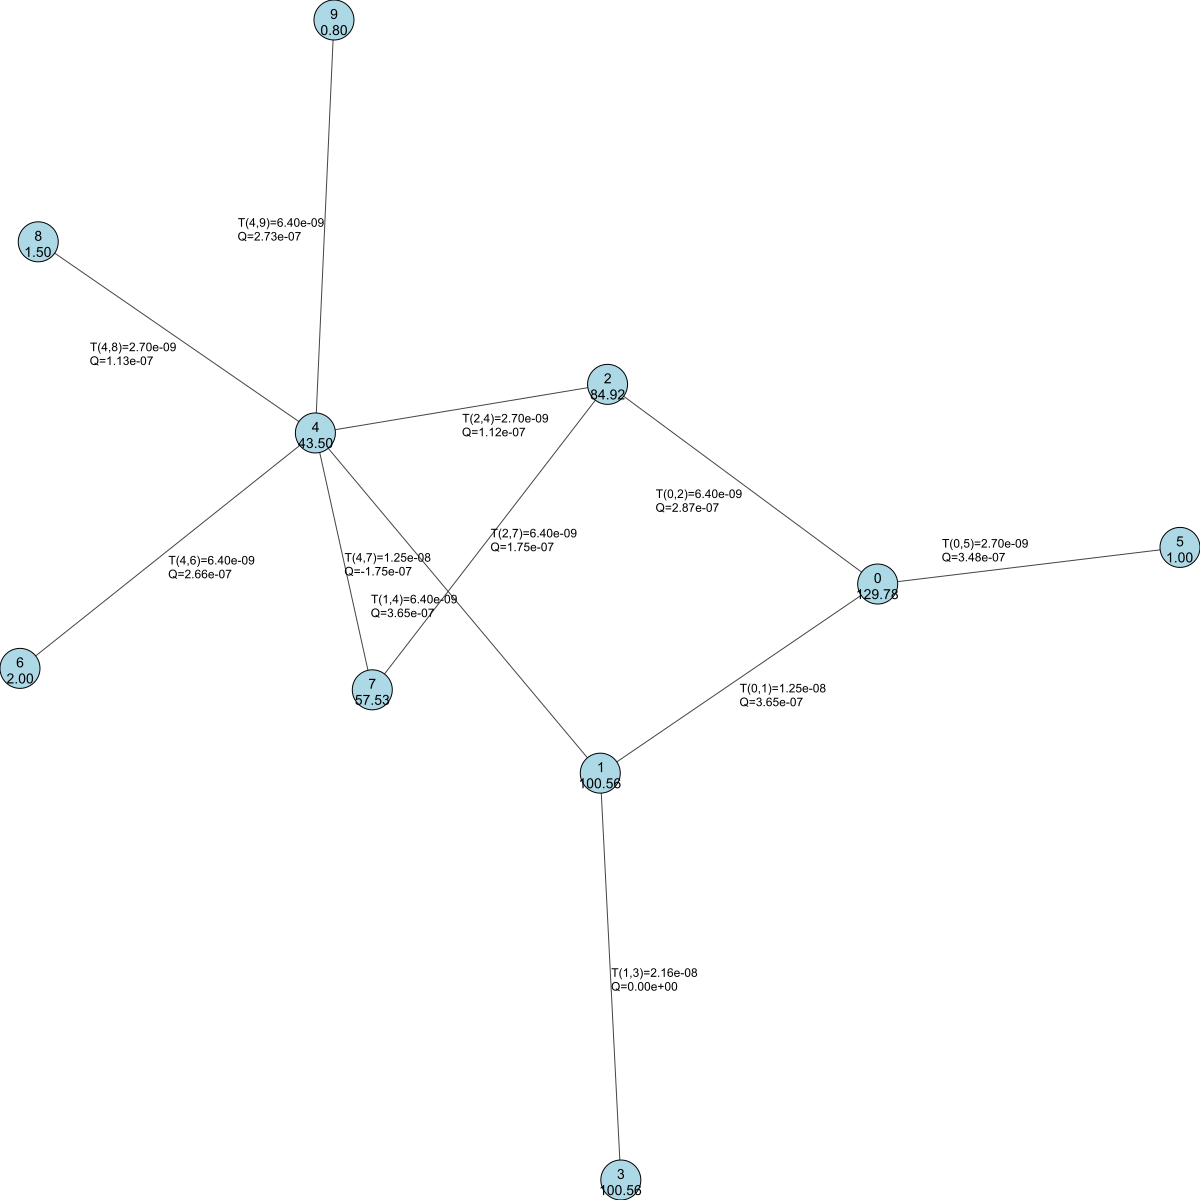

In [15]:
import igraph as ig
import numpy as np

# Create empty graph
g = ig.Graph()

# Add nodes
g.add_vertices(10)

# Add edges
aristas = [(0,1), (0,2), (0,5), (1,3), (1,4), (2,4), (4,6), (4,7), (7,2), (8,4), (9,4)]

g.add_edges(aristas)
ig.plot(g, vertex_label=range(10), vertex_size=30)

# Transmissibilities
n = g.vcount()

# Define diameters and lenghts
diameters = [0.005, 0.004, 0.003, 0.006, 0.004, 0.003, 0.004, 0.005, 0.004, 0.003, 0.004]
lengths = [0.05, 0.04, 0.03, 0.06, 0.04, 0.03, 0.04, 0.05, 0.04, 0.03, 0.04]
# Compute new transmissibilities
T = [(D**4)/L for D, L in zip(diameters, lengths)]
g.es['T'] = T 

# Matrix A
A = np.zeros((n,n))
for edge in g.es:
    i, j = edge.tuple
    Tij = edge['T']
    A[i,i] += Tij
    A[j,j] += Tij
    A[i,j] -= Tij
    A[j,i] -= Tij

# Matrix Q (with neumann condition)
Q = np.zeros(n)
Q[0] = 1e-6  # inflow

# Matrix P with dirichlet nodes 
P_dirichlet = np.zeros(n)
dirichlet_nodes  = [5, 6, 8, 9]
dirichlet_values = [1.0, 2.0, 1.5, 0.8]

# Right hand side of the equation (Q = Tij*P_dirichlet[j])
for node, val in zip(dirichlet_nodes, dirichlet_values):
    P_dirichlet[node] = val
    Q -= A[:, node] * P_dirichlet[node]
#print("A:", A)
#print("Q:", Q)



# Reduce matrixes to only solve por unknows preassures 
A_reduced = np.delete(A, dirichlet_nodes, axis=0)
A_reduced = np.delete(A_reduced, dirichlet_nodes, axis=1)
Q_reduced = np.delete(Q, dirichlet_nodes)

# Solve system
P_unknows = np.linalg.solve(A_reduced, Q_reduced)


# Reconstruct whole preassure vector
P_all = np.zeros(n)
free_nodes = [i for i in range(n) if i not in dirichlet_nodes]
P_all[free_nodes] = P_unknows
P_all[dirichlet_nodes] = dirichlet_values

# Compute flow 
flows = [float(edge['T']*(P_all[i]-P_all[j])) for edge in g.es for i,j in [edge.tuple]]

# Show results
print("Nodal preassure P:", P_all)
print("Flow in edges:", flows)

# Plot
g.vs['label'] = [f"{i}\n{P_all[i]:.2f}" for i in range(n)]
g.es['label'] = [f"{edge['T']}" for edge in g.es]
g.es['flow'] = flows
g.es['edge_label'] = [
    f"T({i},{j})={edge['T']:.2e}\nQ={edge['flow']:.2e}"
    for edge, (i, j) in zip(g.es, [e.tuple for e in g.es])
]

layout = g.layout("kk")
ig.plot(g, layout=layout, vertex_size=40, vertex_color="lightblue",
        vertex_label=g.vs['label'], edge_label=g.es['edge_label'],
        target="blood_flow_toy_graph.png", edge_label_angle_auto=True,  bbox=(1200, 1200) )


Nodes 5, 6, 8, and 9 are Dirichlet and have exactly the values you set: [1, 2, 1.5, 0.8].

The other nodes show very high pressures (for example, 129 at node 0).

This happens because:

- You only set a very small input flow, Q[0] = 1e-6.

- The transmissibilities T are very small (D^4/L with D ~ 0.003–0.006, L ~ 0.03–0.06), generating high resistance.

How to solve? 
- Reduce inflow (~e-7)
- Multiply T by a factor = bigger flows and normal preassures (increase numbers for visibility)

# FRANCA'S GRAPH

In [16]:
import igraph as ig
import numpy as np

# Create an empty graph
g = ig.Graph()

# Add nodes
g.add_vertices(12)

# Add edges
e = [(1,2), (1,3), (1,4), (1,5), (2,8), (2,14), (3,4), (3, 13), (4, 12), (5,6), (6,7), (6,11), 
     (7,10), (7,8), (8,9)]

g.add_edges(e)
ig.plot(g, vertex_label=range(10), vertex_size=30)

# Transmissibilities
# Adding transmissibility attribute
g.es['T'] = 1 * g.ecount()

# Matrix A
n = g.vcount()
A = np.zeros((n,n))
# Fill matrix A with transmissibilities
for edge in g.es:
    i, j = edge.tuple
    Tij = edge['T']
    A[i,i] += Tij
    A[j,j] += Tij
    A[i,j] -= Tij
    A[j,i] -= Tij

# Matrix Q (flow matrix)
Q = np.zeros(n)
 # Neumann condition (inflow in node O)
Q[0] = 1e-6 

# Matrix P with dirichlet nodes 
P_dirichlet = np.zeros(n)
dirichlet_nodes  = [5, 6, 8, 9]
dirichlet_values = [1.0, 2.0, 1.5, 0.8]

# Right hand side of the equation (Q = Tij*P_dirichlet[j])
for node, val in zip(dirichlet_nodes, dirichlet_values):
    P_dirichlet[node] = val
    Q -= A[:, node] * P_dirichlet[node]
#print("A:", A)
#print("Q:", Q)



# Reduce matrixes to only solve por unknows preassures 
A_reduced = np.delete(A, dirichlet_nodes, axis=0)
A_reduced = np.delete(A_reduced, dirichlet_nodes, axis=1)
Q_reduced = np.delete(Q, dirichlet_nodes)

print("red", A_reduced)
print("q_red", Q_reduced)

# Solve system
P_unknows = np.linalg.solve(A_reduced, Q_reduced)
print(P_unknows)

# Reconstruct whole preassure vector
P_all = np.zeros(n)
free_nodes = [i for i in range(n) if i not in dirichlet_nodes]
P_all[free_nodes] = P_unknows
P_all[dirichlet_nodes] = dirichlet_values

# Compute flow 
flows = [float(edge['T']*(P_all[i]-P_all[j])) for edge in g.es for i,j in [edge.tuple]]

# Show results
print("Nodal preassure P:", P_all)
print("Flow in edges:")

# Plot
g.vs['label'] = [f"{i}\n{P_all[i]:.2f}" for i in range(n)]
g.es['label'] = [f"{edge['T']}" for edge in g.es]
g.es['flow'] = flows
g.es['edge_label'] = [
    f"T({i},{j})={edge['T']:.2e}\nQ={edge['flow']:.2e}"
    for edge, (i, j) in zip(g.es, [e.tuple for e in g.es])
]

layout = g.layout("kk")
ig.plot(g, layout=layout, vertex_size=40, vertex_color="lightblue",
        vertex_label=g.vs['label'], edge_label=g.es['edge_label'],
        target="blood_flow_toy_graph.png", edge_label_angle_auto=True,  bbox=(1200, 1200) )


InternalError: Error at src/graph/type_indexededgelist.c:267: Out-of-range vertex IDs when adding edges. -- Invalid vertex ID

In [19]:
import igraph as ig
import numpy as np

g = ig.Graph()
g.add_vertices(14)  # internal nodes 0..13 <=> Franca's nodes 1..14

# edges listed in original numbering (1..14)
edges_original = [
    (1,2), (1,3), (1,4), (1,5),
    (2,8), (2,14),
    (3,4), (3,13),
    (4,12),
    (5,6),
    (6,7), (6,11),
    (7,10), (7,8),
    (8,9)
]
# convert to 0-based for igraph
edges = [(a-1, b-1) for a,b in edges_original]
g.add_edges(edges)


# Transmissibilities for each edge (in same order)
T_values = [
    0.40,  # T0: edge (1,2)
    0.35,  # T1: edge (1,3)
    0.30,  # T2: edge (1,4)
    0.25,  # T3: edge (1,5)
    0.18,  # T4: edge (2,8)
    0.12,  # T5: edge (2,14)
    0.50,  # T6: edge (3,4)
    0.14,  # T7: edge (3,13)
    0.16,  # T8: edge (4,12)
    0.45,  # T9: edge (5,6)
    0.40,  # T10: edge (6,7)
    0.22,  # T11: edge (6,11)
    0.28,  # T12: edge (7,10)
    0.33,  # T13: edge (7,8)
    0.37   # T14: edge (8,9)
]
# assign to graph edges
g.es['T'] = T_values


# Build conductance matrix A
n = g.vcount()
A = np.zeros((n, n), dtype=float)
for edge, Tij in zip(g.get_edgelist(), g.es['T']):
    i, j = edge
    A[i,i] += Tij
    A[j,j] += Tij
    A[i,j] -= Tij
    A[j,i] -= Tij

# Flow vector Q (Neumann)
Q = np.zeros(n, dtype=float)
Q[4] = 1.0 # inflow at node 5

# Dirichlet: nodes 9..14 (human) -> indices 8..13
dirichlet_human = [9, 10, 11, 12, 13, 14]
dirichlet_nodes = [d-1 for d in dirichlet_human]
# Dirichlet values (random):
dirichlet_values_human = {9:1.20, 10: 1.15, 11: 1.10, 12: 1.05, 13: 1.00, 14: 0.95}
# build vector of dirichlet values aligned to indices
P_dirichlet = np.zeros(n, dtype=float)

for human_node, val in dirichlet_values_human.items():
    node = human_node - 1
    P_dirichlet[node] = val
    # move known pressures to RHS: Q = Q - A[:,node]*P_dirichlet[node]
    Q -= A[:, node] * P_dirichlet[node]


# Reduce system to unknown pressures
free_nodes = [i for i in range(n) if i not in dirichlet_nodes]
A_reduced = A[np.ix_(free_nodes, free_nodes)]
Q_reduced = Q[free_nodes]

print("A_reduced",A_reduced)
print("Q_reduced",Q_reduced)

# Solve linear system
P_unknowns = np.linalg.solve(A_reduced, Q_reduced)

# Reconstruct full pressure vector (in internal indexing)
P_all = np.zeros(n, dtype=float)
for node, pval in zip(free_nodes, P_unknowns):
    P_all[node] = pval
for node in dirichlet_nodes:
    P_all[node] = P_dirichlet[node]


# Compute flows on edges 
flows = []
for (i,j), Tij in zip(edges, g.es['T']):
    q = Tij * (P_all[i] - P_all[j])
    flows.append(q)


# Print results (using numbering 1..14)
print("Nodal pressures (human numbering 1..14):")
for human_idx in range(1, n+1):
    print(f"P{human_idx} = {P_all[human_idx-1]:.6f}")

print("\nFlows (edges listed as in your original list):")
for (a,b), q in zip(edges_original, flows):
    print(f"Q({a},{b}) = {q:.6e}")

# -----------------------------
# (Optional) attach labels and plot to file
# -----------------------------
g.vs['label'] = [f"{i+1}\n{P_all[i]:.2f}" for i in range(n)]
g.es['label'] = [f"{t:.2f}\n{q:.2e}" for t,q in zip(g.es['T'], flows)]
layout = g.layout("fr")
ig.plot(g, layout=layout, vertex_size=40, vertex_color="lightblue",
        vertex_label=g.vs['label'], edge_label=g.es['label'],
        target="blood_flow_numeric_graph.png", bbox=(900,900))
print("\nPlot saved to 'blood_flow_numeric_graph.png'")


A_reduced [[ 1.3  -0.4  -0.35 -0.3  -0.25  0.    0.    0.  ]
 [-0.4   0.7   0.    0.    0.    0.    0.   -0.18]
 [-0.35  0.    0.99 -0.5   0.    0.    0.    0.  ]
 [-0.3   0.   -0.5   0.96  0.    0.    0.    0.  ]
 [-0.25  0.    0.    0.    0.7  -0.45  0.    0.  ]
 [ 0.    0.    0.    0.   -0.45  1.07 -0.4   0.  ]
 [ 0.    0.    0.    0.    0.   -0.4   1.01 -0.33]
 [ 0.   -0.18  0.    0.    0.    0.   -0.33  0.88]]
Q_reduced [0.    0.114 0.14  0.168 1.    0.242 0.322 0.444]
Nodal pressures (human numbering 1..14):
P1 = 2.236883
P2 = 1.844849
P3 = 1.863971
P4 = 1.844844
P5 = 3.856659
P6 = 2.534313
P7 = 1.835546
P8 = 1.570231
P9 = 1.200000
P10 = 1.150000
P11 = 1.100000
P12 = 1.050000
P13 = 1.000000
P14 = 0.950000

Flows (edges listed as in your original list):
Q(1,2) = 1.568133e-01
Q(1,3) = 1.305192e-01
Q(1,4) = 1.176117e-01
Q(1,5) = -4.049442e-01
Q(2,8) = 4.943136e-02
Q(2,14) = 1.073819e-01
Q(3,4) = 9.563362e-03
Q(3,13) = 1.209559e-01
Q(4,12) = 1.271750e-01
Q(5,6) = 5.950558e-01
Q(6,7) 

In [ ]:
import numpy as np

## --- 1. System Data Definition (Based on your exact output) ---

# Nodal Pressures (P_i) - Using exact 6 decimal places from the output
P = {
    1: 2.236883, 2: 1.844849, 3: 1.863971, 4: 1.844844,
    5: 3.856659, 8: 1.570231, 14: 0.950000  # P14 is Dirichlet
}

# Transmissibilities (T_i,j) - Inferred from A_reduced (A_i,j = -T_i,j)
T = {
    (1, 2): 0.40, (1, 3): 0.35, (1, 4): 0.30, (1, 5): 0.25,
    (2, 8): 0.18, (2, 14): 0.12,
}

TOLERANCE = 1e-6  # Tolerance for verification (to account for floating point math)

def get_T(i, j):
    """Retrieves T(i,j) or T(j,i)."""
    return T.get((i, j)) or T.get((j, i))

def print_flow_step(i, j, P_values, T_values):
    """Calculates and prints the detailed substitution step for Q_i,j."""
    Tij = get_T(i, j)
    if Tij is None:
        raise ValueError(f"T not defined for ({i}, {j})")

    # Use the exact floating point values for calculation
    dP = P_values[i] - P_values[j]
    Qij = Tij * dP

    # Output format replicating the requested style (using 6 decimal places for display)
    print(f"T({i},{j})(P{i} - P{j}) = {Tij:.2f} * ({P_values[i]:.6f} - {P_values[j]:.6f}) = {Tij:.2f} * ({dP:.6f}) = **{Qij:.6f}**")
    return Qij

## --- 3. Verification of Node 1: Sum of Q = 0 ---

print("\n" + "="*70)
print("VERIFICATION (Node 1)")
print("Equation: T(1,2)(P1 - P2) + T(1,3)(P1 - P3) + T(1,4)(P1 - P4) + T(1,5)(P1 - P5) = 0")
print("="*70)

Q_terms_node1 = []
print("Substitution and Calculation:")
Q_terms_node1.append(print_flow_step(1, 2, P, T))
Q_terms_node1.append(print_flow_step(1, 3, P, T))
Q_terms_node1.append(print_flow_step(1, 4, P, T))
Q_terms_node1.append(print_flow_step(1, 5, P, T))

sum_Q_node1 = np.sum(Q_terms_node1)
print("\nTotal Sum:")
# Using scientific notation for the final sum to show its magnitude (close to zero)
print(f"Result of the Sum: {' + '.join([f'{q:.6f}' for q in Q_terms_node1])} = **{sum_Q_node1:.6e}**")

print("\nVerification:")
if np.abs(sum_Q_node1) < TOLERANCE:
    print(f"**{sum_Q_node1:.6e} ≈ 0 (Flow conservation is satisfied. ✅)**")
else:
    print(f"Conservation Error: {sum_Q_node1}")


## --- 4. Verification of Node 2: Sum of Q = 0 ---

print("\n" + "="*70)
print("VERIFICATION (Node 2)")
print("Equation: T(1,2)(P2 - P1) + T(2,8)(P2 - P8) + T(2,14)(P2 - P14) = 0")
print("="*70)

Q_terms_node2 = []
print("Substitution and Calculation:")
Q_terms_node2.append(print_flow_step(2, 1, P, T))
Q_terms_node2.append(print_flow_step(2, 8, P, T))
Q_terms_node2.append(print_flow_step(2, 14, P, T))

sum_Q_node2 = np.sum(Q_terms_node2)
print("\nTotal Sum:")
print(f"Result of the Sum: {' + '.join([f'{q:.6f}' for q in Q_terms_node2])} = **{sum_Q_node2:.6e}**")

print("\nVerification:")
if np.abs(sum_Q_node2) < TOLERANCE:
    print(f"**{sum_Q_node2:.6e} ≈ 0 (Flow conservation is satisfied. ✅)**")
else:
    print(f"Conservation Error: {sum_Q_node2}")

In [ ]:
import numpy as np

## --- 1. System Data Definition ---

# Nodal Pressures (P_i) - Solution calculated from the system
P = {
    1: 2.236883,
    5: 3.856659,  # P5 is the highest pressure node
    6: 2.534313   # P6 is connected to P5
}

# Transmissibilities (T_i,j) - Inferred from A_reduced
T = {
    (1, 5): 0.25,  # T_1,5 = -A_1,5 = -(-0.25)
    (5, 6): 0.45,  # T_5,6 = -A_5,6 = -(-0.45)
}

Q_EXTERNAL = 1.0  # External inflow q5 at Node 5
TOLERANCE = 1e-6  # Tolerance for verification (for floating point math)

def get_T(i, j):
    """Retrieves T(i,j) or T(j,i)."""
    return T.get((i, j)) or T.get((j, i))

def print_flow_step(i, j, P_values, T_values):
    """Calculates and prints the detailed substitution step for Q_i,j."""
    Tij = get_T(i, j)
    if Tij is None:
        raise ValueError(f"T not defined for ({i}, {j})")

    dP = P_values[i] - P_values[j]
    Qij = Tij * dP

    # Output format replicating the requested style
    print(f"T({i},{j})(P{i} - P{j}) = {Tij:.2f} * ({P_values[i]:.6f} - {P_values[j]:.6f}) = {Tij:.2f} * ({dP:.6f}) = **{Qij:.6f}**")
    return Qij

## --- 2. Verification of Node 5: Sum of Q = q5 ---

print("\n" + "="*70)
print("VERIFICATION (Node 5 - Inflow Node)")
print("Equation: T(1,5)(P5 - P1) + T(5,6)(P5 - P6) = q5 = 1.0")
print("="*70)

Q_terms_node5 = []
print("Substitution and Calculation:")
# Note: Flows are calculated assuming P5 is the origin (P5 - Pj)
Q_terms_node5.append(print_flow_step(5, 1, P, T))
Q_terms_node5.append(print_flow_step(5, 6, P, T))

sum_Q_node5 = np.sum(Q_terms_node5)
print("\nTotal Sum:")
print(f"Result of the Sum: {' + '.join([f'{q:.6f}' for q in Q_terms_node5])} = **{sum_Q_node5:.6e}**")

print("\nVerification:")
if np.abs(sum_Q_node5 - Q_EXTERNAL) < TOLERANCE:
    print(f"**{sum_Q_node5:.6e} ≈ {Q_EXTERNAL:.1f} (Flow conservation is satisfied. ✅)**")
else:
    print(f"Conservation Error: {sum_Q_node5 - Q_EXTERNAL:.6e}")